In [ ]:
# please comment out once downloaded once to avoid re-downloading at each run !
# !wget https://perso.liris.cnrs.fr/nicolas.bonneel/diffusion/unets.py
# !wget https://perso.liris.cnrs.fr/nicolas.bonneel/diffusion/fullmodel_unetsmall_faces.pt
# !wget https://perso.liris.cnrs.fr/nicolas.bonneel/diffusion/fullmodel_unetsmall_photos.pt
# !wget https://perso.liris.cnrs.fr/nicolas.bonneel/diffusion/fullmodel_unet_faces.pt


import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import time
from mpl_toolkits.axes_grid1 import ImageGrid
import unets

t_max = 500  # 1000 for unet_faces, 500 for unetsmall_faces, or 200 for the photo dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = unets.UNetSmall(image_size=128, in_channels=3, out_channels=3, num_classes=None).to(device)

alpha_t_vec = 1-np.linspace(0.0001, 0.02, t_max)
alpha_bar_t_vec = np.cumprod(alpha_t_vec)

checkpoint = torch.load("./fullmodel_unetsmall_faces.pt", weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])

training = False


if training:
    resize_transform = transforms.Compose([ transforms.Resize(size=(128,128)), transforms.PILToTensor(), transforms.ConvertImageDtype(torch.float32) ]);

    dataset = datasets.ImageFolder(root = "./data",
                             transform = resize_transform)

    loader = torch.utils.data.DataLoader(dataset = dataset,
                                        batch_size = 1,
                                        shuffle = True)
    loss_function = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

    prefetched_images = []
    for (image, _) in loader:
        prefetched_images.append(np.squeeze(image*2.0-1.0))

    epochs =  int(2505*12)
    outputs = []
    losses = []
    batch_size = 8

    start_time = time.time()
    for epoch in range(epochs):
        random.shuffle(prefetched_images)

        #for i in range(0, int(4936/batch_size) ):
        for i in range(0, int(48/batch_size) ):
            batch = prefetched_images[(i*batch_size):(i*batch_size+batch_size)]
            image = torch.stack(batch, dim=0)
            img = image.to(device)
            t = np.random.random_integers(0, t_max-1, size=(batch_size))

            eps_0_t = torch.randn(img.size(), device=device)
            alpha_bar_t = torch.from_numpy(alpha_bar_t_vec[t]).to(device=device).view((batch_size, 1, 1, 1)).float()
            noisy_img = torch.sqrt(alpha_bar_t) * img + torch.sqrt(1-alpha_bar_t)*eps_0_t

            predicted_noise_value = model(noisy_img, torch.from_numpy(t).float().to(device=device))

            loss = loss_function(predicted_noise_value, eps_0_t)

            reconstructed = (noisy_img - torch.sqrt(1-alpha_bar_t)*predicted_noise_value)/torch.sqrt(alpha_bar_t)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.cpu().detach())

    print("--- %s seconds ---" % (time.time() - start_time))

    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, "./fullmodel.pt")


    plt.figure(0)

    plt.style.use('fivethirtyeight')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')

    plt.plot(losses[10:])

    # Show noisy images
    fig = plt.figure(1, figsize=(6, 6))
    grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0.01,
                 )
    for i, (ax, item)  in enumerate(zip(grid, noisy_img.cpu().detach())):
        if i==16:
            break
        item = (np.transpose(item.reshape(3, 128, 128), (1,2,0))+1.0)/2.0
        ax.imshow(item)

    # Show denoised images
    fig = plt.figure(2, figsize=(6, 6))
    grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0.01,
                 )

    for i, (ax, item) in enumerate(zip(grid , reconstructed.cpu().detach())):
        if i==16:
            break
        item = (np.transpose(item.reshape(3, 128, 128),(1,2,0))+1.0)/2.0
        ax.imshow(item)


### the denoiser has been learnt.

### Now generate an image

noisy_img = torch.randn((1,3,128,128), device=device)

model.eval()
with torch.no_grad():
  # loop over time and progressively denoise your randn

    for t in range(t_max-1, 0, -1):
        
        alpha_t = torch.tensor(alpha_t_vec[t], device=device)
        alpha_t_bar = torch.tensor(alpha_bar_t_vec[t], device=device)

        t_tensor = torch.full((noisy_img.size(0),), t, device=device, dtype=torch.float32)
        eps = model(noisy_img, t_tensor)

        noisy_img = (noisy_img - eps * ((1 - alpha_t) / torch.sqrt(1 - alpha_t_bar))) / torch.sqrt(alpha_t)

        if t > 1:
            sigma_t = ((1 - alpha_t) * (1 - alpha_bar_t_vec[t - 1]) / (1 - alpha_t_bar)).sqrt()
            z = torch.randn_like(noisy_img)
            noisy_img += sigma_t * z

--2025-04-30 17:51:47--  https://perso.liris.cnrs.fr/nicolas.bonneel/diffusion/unets.py
Resolving perso.liris.cnrs.fr (perso.liris.cnrs.fr)... 134.214.142.28
Connecting to perso.liris.cnrs.fr (perso.liris.cnrs.fr)|134.214.142.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31090 (30K) [text/x-python]
Saving to: ‘unets.py’

unets.py            100%[===================>]  30.36K  --.-KB/s    in 0.008s  

2025-04-30 17:51:48 (3.74 MB/s) - ‘unets.py’ saved [31090/31090]

--2025-04-30 17:51:48--  https://perso.liris.cnrs.fr/nicolas.bonneel/diffusion/fullmodel_unetsmall_faces.pt
Resolving perso.liris.cnrs.fr (perso.liris.cnrs.fr)... 134.214.142.28
Connecting to perso.liris.cnrs.fr (perso.liris.cnrs.fr)|134.214.142.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77294083 (74M)
Saving to: ‘fullmodel_unetsmall_faces.pt’

fullmodel_unetsmall 100%[===================>]  73.71M  89.7MB/s    in 0.8s    

2025-04-30 17:51:49 (89.7 MB/s) - ‘fu

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


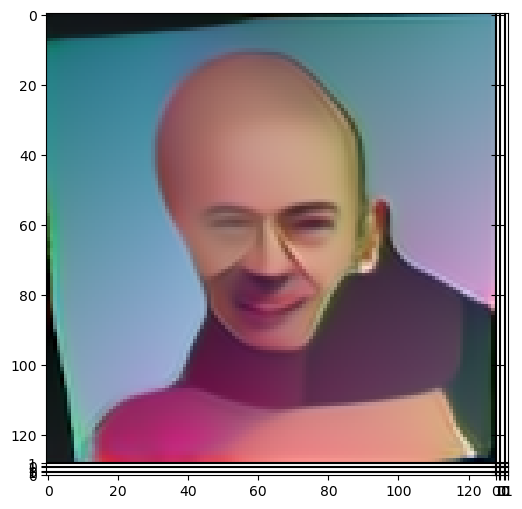

In [45]:
fig = plt.figure(2, figsize=(6, 6))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0.01,
                 )

for i, (ax, item) in enumerate(zip(grid , noisy_img.cpu().detach())):
    if i==16:
        break
    item = (np.transpose(item.reshape(3, 128, 128),(1,2,0))+1.0)/2.0
    ax.imshow(item)
